In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
import decimal

def drange(x : int, y : int, jump : float, digits : int):
    """
    Range for float numbers
    """
    jump = decimal.Decimal(jump)
    while x < y:
        yield round(float(x), digits)
        x += jump

### Визуализация данных

In [2]:
df = pd.read_csv('data.csv', names=['Title', 'alltime', 'lastyear'])
df

,Title,alltime,lastyear
0,Зеленая миля,9.1,9.2
1,Список Шиндлера,8.8,9.1
2,Побег из Шоушенка,9.1,9.0
3,Форрест Гамп,8.9,8.9
4,Властелин колец: Возвращение короля,8.6,8.9
...,...,...,...
245,Крепкий орешек,8.0,8.1
246,Хранители снов,7.9,8.1
247,Небесный замок Лапута,8.2,8.1
248,Убить Билла,7.7,8.1


In [3]:
df.describe()

,alltime,lastyear
count,250.00000,250.000000
mean,8.21400,8.310400
std,0.25127,0.209157
min,7.70000,8.100000
25%,8.00000,8.200000
50%,8.20000,8.300000
75%,8.40000,8.400000
max,9.10000,9.200000


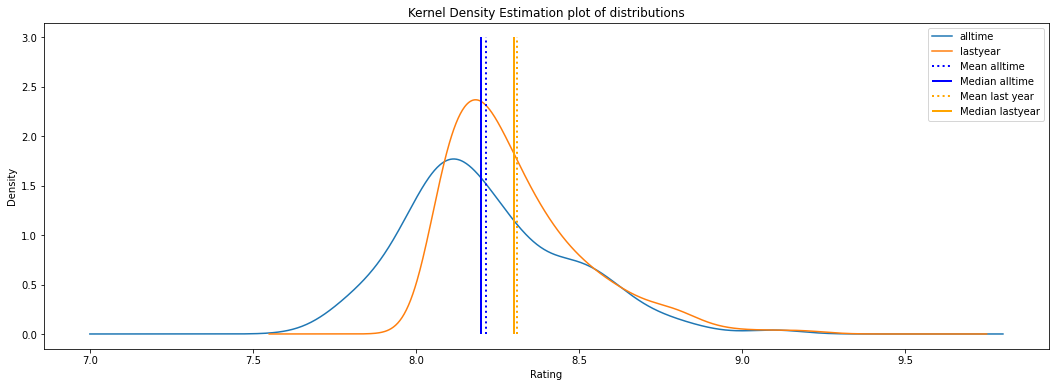

In [4]:
alltime = df.loc[:, ['alltime']]
lastyear = df.loc[:, ['lastyear']]
data = df.loc[:, ['alltime','lastyear']]
data.plot(kind='density', figsize = (18,6), title = 'Kernel Density Estimation plot of distributions', )
plt.xlabel('Rating')
plt.vlines(alltime.mean(), ymin = 0.0, ymax = 3.0,
           linewidth = 2, linestyles = 'dotted', color = 'blue', label = 'Mean alltime')
plt.vlines(alltime.median(), ymin = 0.0, ymax = 3.0,
           linewidth = 2, linestyles = 'solid', color = 'blue', label = 'Median alltime')
plt.vlines(lastyear.mean(), ymin = 0.0, ymax = 3.0,
           linewidth = 2, linestyles = 'dotted', color = 'orange', label = 'Mean last year')
plt.vlines(lastyear.median(), ymin = 0.0, ymax = 3.0,
           linewidth = 2, linestyles = 'solid', color = 'orange', label = 'Median lastyear')
plt.legend()
plt.show()

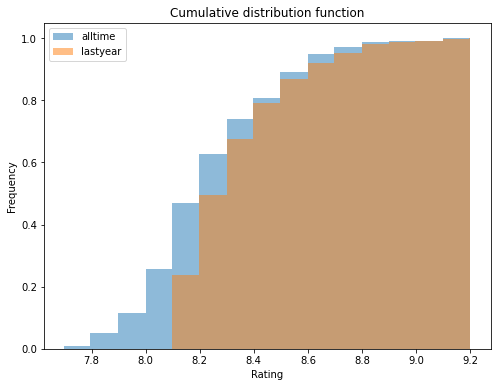

In [5]:
data.plot(kind='hist', cumulative=True, density=1, bins=len(data), 
          figsize = (8,6), alpha = 0.5, title = "Cumulative distribution function")
plt.xlabel("Rating")
plt.show()

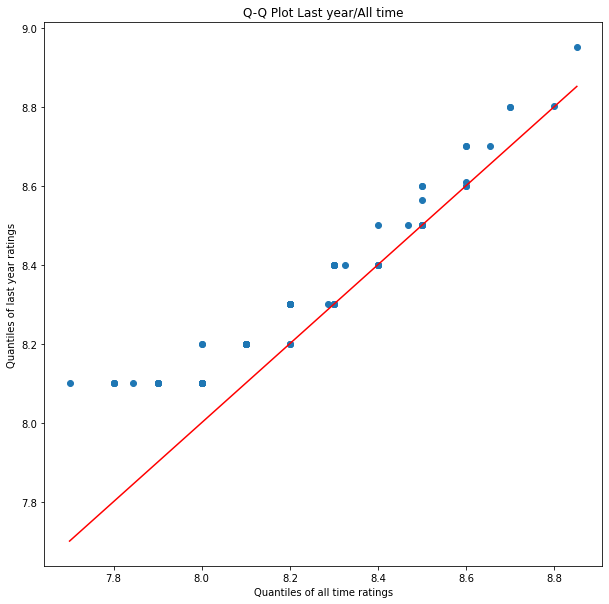

In [6]:
data_percentile = data.quantile(list(drange(0,1,0.01, 2)))
plt.figure(figsize=(10,10))
plt.scatter(x = "alltime", y = "lastyear", data = data_percentile)
plt.plot(data_percentile.loc[:, ['alltime']], data_percentile.loc[:, ['alltime']], color = "red")
plt.title("Q-Q Plot Last year/All time")
plt.xlabel("Quantiles of all time ratings")
plt.ylabel("Quantiles of last year ratings")
plt.show()

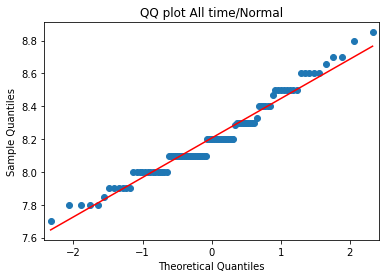

In [7]:
fig = sm.qqplot(data_percentile.loc[:, ['alltime']], line='s')
plt.title("QQ plot All time/Normal")
plt.show()


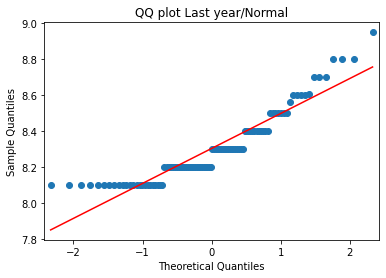

In [8]:
fig = sm.qqplot(data_percentile.loc[:, ['lastyear']], line='s')
plt.title("QQ plot Last year/Normal")
plt.show()

* Будем сравнивать распределеие рейтингов за последний год с распределением за все время. На всех графиках видно, что левый хвост рейтингов за все время является более длинным чем у рейтингов за последний год. Это соотвествующим образом влияет на дисперсию и среднее значение распределения оценок за все время. Это говорит о том, что люди стали более положительно относиться к некоторым фильмам со временем, что позволило им попать в топ, так как топ получается исходя из рейтинга за последний год.
* Проведем тесты по сравнению данных распределений

### Статистические тесты

Перед тем как провести тесты на равество среднего и медеаны желательно провести тесты на нормальность и равенство дисперсий. Исходя из полученных графиков и здравого смысла кажется, что распределения соответствуют нормальному, однако имеют различную дисперсию. Для всех тестов будем использовать уровень значимости равный 0.05


Будем использовать тест Шапиро-Уилка для проверки на нормальность, так как он имеет большую мощность относительно других тестов.

Н0 - Распределение является нормальным

Н1 - Распределение не является нормальным

In [9]:
from scipy.stats import shapiro, kstest, normaltest
print(shapiro(alltime))
print(shapiro(lastyear))
print(kstest(np.array(alltime)[:,0], 'norm'))
print(kstest(np.array(lastyear)[:,0], 'norm'))
print(normaltest(alltime))
print(normaltest(lastyear))

ShapiroResult(statistic=0.9552043676376343, pvalue=5.470464543577691e-07)
ShapiroResult(statistic=0.8542722463607788, pvalue=1.2837025720028889e-14)
KstestResult(statistic=0.9999999999999932, pvalue=0.0)
KstestResult(statistic=0.9999999999999998, pvalue=0.0)
NormaltestResult(statistic=array([19.22800892]), pvalue=array([6.67868427e-05]))
NormaltestResult(statistic=array([62.97695808]), pvalue=array([2.11216242e-14]))


Так как `p-value` гораздо меньше 0.05 то мы отвергаем основную гипотезу о нормальности. Похоже тут смесь нормальных распределений, напрашивается EM алгоритм для кластеризации....

Для проверки того что распределения имеют различную дисперсию будем использовать тесты Бартлетта, Левена.

В scipy указано что тест Левена более надежный в случае когда данные не распределены нормально

Н0 Дисперсии двух распределений равны
Н1 Дисперсии не равны

In [10]:
from scipy.stats import bartlett, levene
print(bartlett(np.array(alltime)[:,0], np.array(lastyear)[:,0]))
print(levene(np.array(alltime)[:,0], np.array(lastyear)[:,0]))

BartlettResult(statistic=8.315666553494221, pvalue=0.003930457779229303)
LeveneResult(statistic=7.736719583562222, pvalue=0.005616066872505271)


Тут без сюрпризов, как и ожидалось мы отклоняем нулевую гипотезу о равенстве дисперсий.

Проведем тест на равенство средних значений двух выборок.

Так как мы не можем делать никаких предположений о распределениях желательно использовать Критерий Манна-Уитни или Бруннера-Мюнцеля больше подходящий для выборок с разными дисперсиями. Однако, также допустимо использовать критерий Уэлча, хотя он не подходит, так как требует нормального распределения и непарных выборок.

Зададим основную и альтернативную гипотезы и применим критерий Уэлча.

Н0 - Разлийчий в среднем значении между выборками `alltime` и `lastyear` нет

Н1 - Различия есть

In [11]:
from scipy.stats import ttest_ind

print(ttest_ind(alltime, lastyear))
print(ttest_ind(alltime, lastyear, equal_var=False))

Ttest_indResult(statistic=array([-4.6622114]), pvalue=array([4.02281133e-06]))
Ttest_indResult(statistic=array([-4.6622114]), pvalue=array([4.05529099e-06]))


Критерий Уэлча и критерий Стьюдента говорят о том что следует отвергунуть нулевую гипотезу о равенстве средних

Гипотезы для критерия Манна-Уитни:

Н0 - Две группы имеют одно распределение

Н1 - Одна группа имеет меньшие или большие значения чем другая

In [12]:
from scipy.stats import mannwhitneyu, brunnermunzel

print(mannwhitneyu(alltime, lastyear))
print(brunnermunzel(alltime, lastyear))

MannwhitneyuResult(statistic=array([23044.5]), pvalue=array([2.67035613e-07]))
BrunnerMunzelResult(statistic=5.294145143633372, pvalue=1.9709212839558177e-07)


Еще пара тестов

In [13]:
# Permutation Test
a = np.array(alltime)[:,0]
y = np.array(lastyear)[:,0]
both = np.concatenate([a, y])

sample_stat = np.mean(y) - np.mean(a)
stats = np.zeros(250)
for k in range(250):
    b = np.random.choice([True, False], 500)
    stats[k] = np.mean(both[b == True]) - np.mean(both[b == False])
print("pvalue =", np.mean(np.array(list(map(lambda x: x > sample_stat, stats)))))
# np.random.permutation(all)

pvalue = 0.0


In [14]:
print(kstest(np.array(lastyear)[:,0], np.array(alltime)[:,0]))

KstestResult(statistic=0.256, pvalue=1.3195189128749187e-07)


Таким образом можно сделать вывод что данные распределения имеют статистически значимые различия среднего значения, медианы, дисперсии, а также являются "неидентичными" согласно некоторым тестам и не являются нормальными.